## Notebook 02: Heat in Place and Barebones Thermoeconomics

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import curve_fit

<>:100: SyntaxWarning: invalid escape sequence '\c'
<>:100: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1p/jdcprp414tsg3dl650mtvk780000gn/T/ipykernel_77573/3432318067.py:100: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ylabel('Specific Heat Capacity ($J/kg \cdot K$)', fontsize=12)


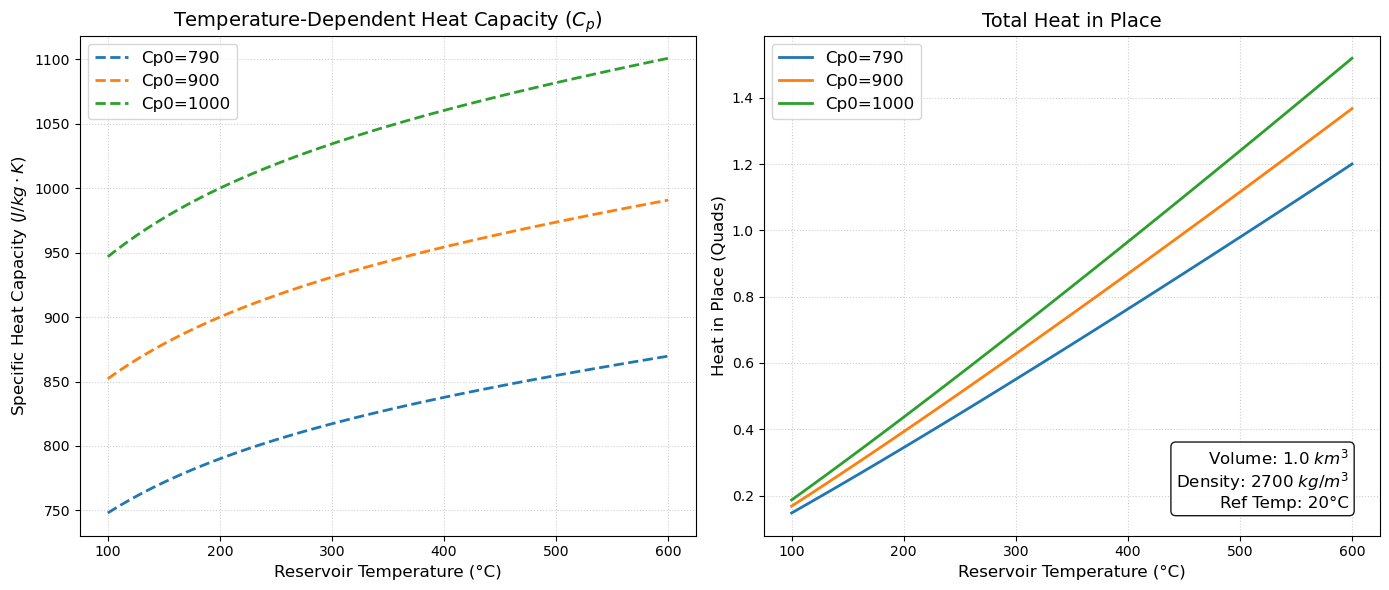

In [27]:


def f_cp_granite_emirov_scalar(T_K, Cp_0):
    """
    Helper function for scalar integration (used by quad).
    Calculates Cp at a single temperature point.
    """
    T0 = 473.0 
    a = 1.0
    b = 0.065
    d = 0.065
    
    # Avoid division by zero
    T_K = max(T_K, 1e-5)
    
    Cp = Cp_0 * (a + b * (T_K / T0) - d * (T_K / T0)**(-2))
    return Cp

def calculate_hip_and_cp(Tres_vec_C, Cp0, T_ref_C=20.0, volume_km3=1.0, density=2700.0):
    """
    Calculates Heat in Place (HIP) in Quads and Specific Heat Capacity (Cp) vectors 
    for a given range of reservoir temperatures and a single Cp0.

    Args:
        T_res_array_C (ndarray): Array of reservoir temperatures (Celsius).
        Cp0 (float): Reference heat capacity (J/kg/K).
        T_ref_C (float): Reference/Surface temperature (Celsius).
        volume_km3 (float): Reservoir volume (km^3).
        density (float): Rock density (kg/m^3).

    Returns:
        tuple: (hip_quads, cp_vals)
            - hip_quads (ndarray): Heat in Place in Quads (10^15 BTU) for each T_res.
            - cp_vals (ndarray): Specific Heat Capacity (J/kg/K) at each T_res.
    """
    
    # 1. Constants and Conversions
    T_ref_K = T_ref_C + 273.15
    Tres_vec_K = Tres_vec_C + 273.15
    
    # Mass of Rock
    mass_kg = volume_km3 * 1e9 * density
    
    # Unit Conversion: Joules to Quads
    # 1 BTU = 1055.05585 Joules
    # 1 Quad = 10^15 BTU = 1.05505585 * 10^18 Joules
    joules_to_quads = 1.0 / 1.05505585e18
    
    hip_joules_list = []
    cp_vals_list = []

    # 2. Calculation Loop
    for T_res_K in Tres_vec_K:
        
        # A. Calculate Cp at this specific Reservoir Temperature (for return array)
        current_cp = f_cp_granite_emirov_scalar(T_res_K, Cp0)
        cp_vals_list.append(current_cp)
        
        # B. Calculate Enthalpy Change (Integration from T_ref to T_res)
        # We use quad for precision
        delta_h_spec, _ = quad(f_cp_granite_emirov_scalar, T_ref_K, T_res_K, args=(Cp0,))
        
        # Total Heat = Mass * Specific Enthalpy Change
        hip_joules_list.append(mass_kg * delta_h_spec)

    # 3. Convert to Arrays and Quads
    hip_J = np.asarray(hip_joules_list)
    hip_quads = hip_J * joules_to_quads
    cp_vals = np.asarray(cp_vals_list)
    
    return hip_J, hip_quads, cp_vals

# --- MAIN EXECUTION & PLOTTING ---

# 1. Setup Data
T_reservoir_range_C = np.linspace(100, 600, 100) # Range of Reservoir Temps (C)
Cp0_values_to_test = [790, 900, 1000]         # Different Rock Types (J/kg/K)

# 2. Initialize Subplots (1 Row, 2 Columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

# 3. Loop and Plot
for idx, Cp0 in enumerate(Cp0_values_to_test):
    
    # Call the function for this specific Cp0
    hip_curve_J, hip_curve_quads, cp_curve_vals = calculate_hip_and_cp(T_reservoir_range_C, Cp0)
    
    color = colors[idx % len(colors)]
    
    # --- Left Subplot: Heat Capacity (Cp) ---
    ax1.plot(T_reservoir_range_C, cp_curve_vals, color=color, linewidth=2, 
             linestyle='--', label=f'Cp0={Cp0}')
    
    # --- Right Subplot: Heat in Place (Quads) ---
    ax2.plot(T_reservoir_range_C, hip_curve_quads, color=color, linewidth=2, 
             label=f'Cp0={Cp0}')

# 4. Formatting - Left Subplot (Cp)
ax1.set_xlabel('Reservoir Temperature (°C)', fontsize=12)
ax1.set_ylabel('Specific Heat Capacity ($J/kg \cdot K$)', fontsize=12)
ax1.set_title('Temperature-Dependent Heat Capacity ($C_p$)', fontsize=14)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='upper left', fontsize=12)

# 5. Formatting - Right Subplot (HIP)
ax2.set_xlabel('Reservoir Temperature (°C)', fontsize=12)
ax2.set_ylabel('Heat in Place (Quads)', fontsize=12)
ax2.set_title('Total Heat in Place', fontsize=14)
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(loc='upper left', fontsize=12)

# Add a text box for global parameters on the Right Plot
info_text = (f"Volume: 1.0 $km^3$\n"
             f"Density: 2700 $kg/m^3$\n"
             f"Ref Temp: 20°C")
ax2.text(0.95, 0.05, info_text, transform=ax2.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

## Recovery Rate as a function of reservoir temperature
## [PLACEHOLDER FOR RESERVOIR MODELS WE WILL DEVELOP LATER!]
<br>
(hypothetical, poorly constrained curves) <br>
but estimates go like 2-20%, so if a reservoir lasts 50 years, <br>
maybe $\dot{f}_R$ is order 0.02/50 = 0.0004 to 0.2/50  0.004 per year <br> 
get better constraints.. 

In [28]:
# assumption 1: fraction of energy extracted... 

def f_fRdot_Tres(Tres_C_vec,fRdot_min,fRdot_max): 
    fRdot_vec = np.linspace(fRdot_min,fRdot_max,len(T_res_C_vec)) 
    return fRdot_vec

fRdot_min = 0.0004
fRdot_max = 0.0004
fRdot_T_const = f_fRdot_Tres(T_reservoir_range_C,fRdot_min,fRdot_max)

fRdot_T_pos = f_fRdot_Tres(T_reservoir_range_C,fRdot_min,fRdot_max)


## Power plant thermal-electrical conversion efficiencies as a function of input fluid temperature

<>:86: SyntaxWarning: invalid escape sequence '\e'
<>:86: SyntaxWarning: invalid escape sequence '\e'
/var/folders/1p/jdcprp414tsg3dl650mtvk780000gn/T/ipykernel_77573/1212538118.py:86: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\eta_{gen}$, Thermal Efficiency (%)', fontsize=14)


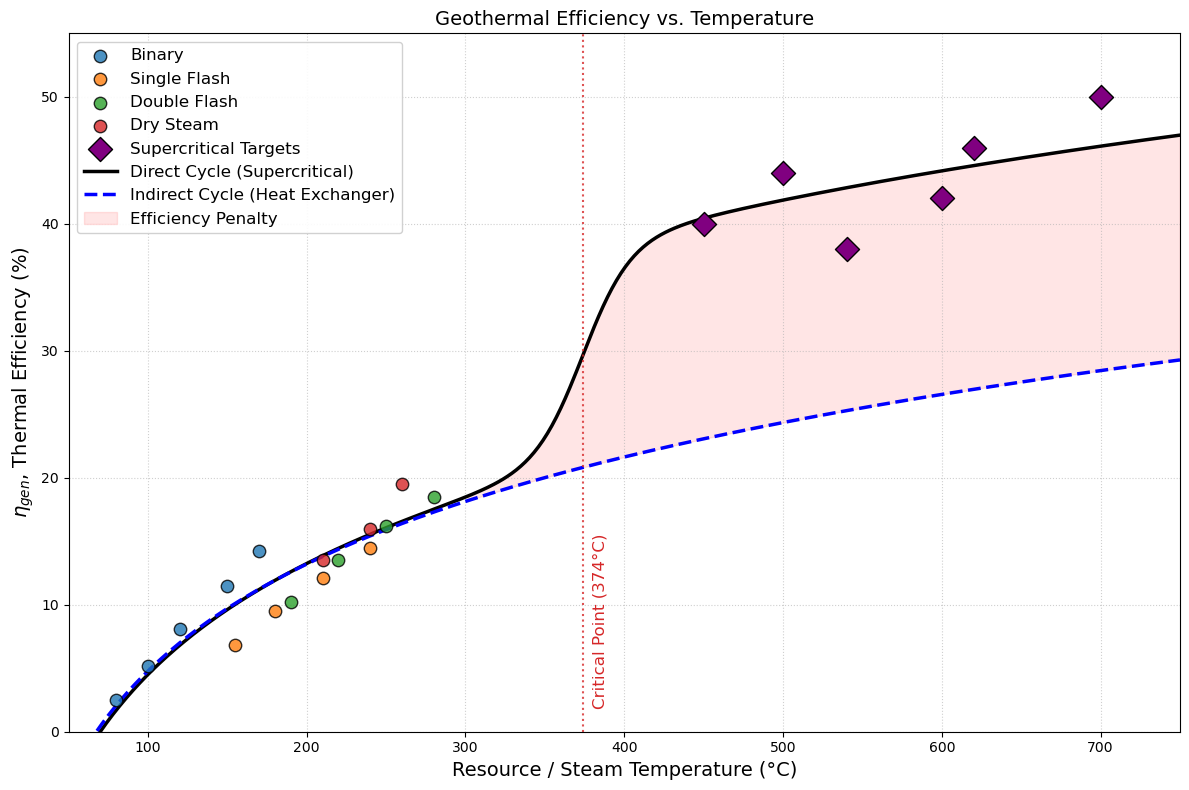

Indirect Fit: a=12.16, b=-51.23
Direct Fit: a=12.61, b=-53.57, K=17.07, w=15.00


In [64]:

# --- DATASET 1: Standard Geothermal (Moon & Zarrouk, 2014) ---
geo_data = {
    'Type': ['Binary']*5 + ['Single Flash']*4 + ['Double Flash']*4 + ['Dry Steam']*3,
    'T': [80, 100, 120, 150, 170, 155, 180, 210, 240, 190, 220, 250, 280, 210, 240, 260],
    'Eff': [2.5, 5.2, 8.1, 11.5, 14.2, 6.8, 9.5, 12.1, 14.5, 10.2, 13.5, 16.2, 18.5, 13.5, 16.0, 19.5]
}
df_geo = pd.DataFrame(geo_data)

# --- DATASET 2: Supercritical (Fossil/Nuclear/IDDP) ---
high_data = {
    'Type': ['Subcritical Coal', 'Supercritical Coal', 'Ultra-Supercritical', 'Advanced USC', 'SC Nuclear', 'IDDP Potential'],
    'T': [540, 600, 620, 700, 500, 450],
    'Eff': [38.0, 42.0, 46.0, 50.0, 44.0, 40.0]
}
df_high = pd.DataFrame(high_data)

# Combined Data for Fitting
all_T = np.concatenate([df_geo['T'], df_high['T']])
all_Eff = np.concatenate([df_geo['Eff'], df_high['Eff']])

# --- MODEL DEFINITIONS ---

# 1. Indirect / Heat Exchanger Model (Logarithmic only)
def model_indirect(T, a, b):
    return a * np.log(T) + b

# 2. Direct / Supercritical Model (Log + Sigmoid Jump)
def model_direct(T, a, b, jump_mag, jump_width):
    base = a * np.log(T) + b
    sigmoid = 1 / (1 + np.exp(-(T - 374) / jump_width))
    return base + jump_mag * sigmoid

# --- FITTING ---

# Fit Indirect Model ONLY to Geothermal Data
popt_indirect, _ = curve_fit(model_indirect, df_geo['T'], df_geo['Eff'])

# Fit Direct Model to ALL Data (with constraints)
#p0_direct = [popt_indirect[0], popt_indirect[1], 15, 30]
p0_direct = [popt_indirect[0], popt_indirect[1], 15, 10]
lower_bounds = [popt_indirect[0]*0.9, -np.inf, 10, 10]
upper_bounds = [popt_indirect[0]*1.1, np.inf, 30, 15] # last entry was 100
popt_direct, _ = curve_fit(model_direct, all_T, all_Eff, p0=p0_direct, bounds=(lower_bounds, upper_bounds))

# --- PLOTTING ---
plt.figure(figsize=(12, 8))

# 1. Plot Geothermal Points (Color Coded)
geo_colors = {
    'Binary': '#1f77b4',       # Blue
    'Single Flash': '#ff7f0e', # Orange
    'Double Flash': '#2ca02c', # Green
    'Dry Steam': '#d62728'     # Red
}

# Loop through types to add to legend individually
for ptype, color in geo_colors.items():
    subset = df_geo[df_geo['Type'] == ptype]
    plt.scatter(subset['T'], subset['Eff'], label=ptype, color=color, s=80, edgecolors='k', alpha=0.8, zorder=3)

# 2. Plot Supercritical Points
plt.scatter(df_high['T'], df_high['Eff'], color='purple', s=150, marker='D', edgecolors='k', label='Supercritical Targets', zorder=3)

# 3. Plot Curves
T_range = np.linspace(50, 750, 500)
curve_indirect = model_indirect(T_range, *popt_indirect)
curve_direct = model_direct(T_range, *popt_direct)

# Plot Direct Curve (Solid Black)
plt.plot(T_range, curve_direct, color='black', linewidth=2.5, label='Direct Cycle (Supercritical)', zorder=2)

# Plot Indirect Curve (Dashed Blue)
plt.plot(T_range, curve_indirect, color='blue', linestyle='--', linewidth=2.5, label='Indirect Cycle (Heat Exchanger)', zorder=2)

# 4. Fill the "Penalty" Gap
plt.fill_between(T_range, curve_indirect, curve_direct, where=(T_range > 300), 
                 color='red', alpha=0.1, label='Efficiency Penalty', zorder=1)

# 5. Annotations
plt.axvline(x=374, color='tab:red', linestyle=':', alpha=0.8)
plt.text(380, 2, 'Critical Point (374°C)', rotation=90, color='tab:red', fontsize=12)

# 6. Formatting
plt.title('Geothermal Efficiency vs. Temperature', fontsize=14)
plt.xlabel('Resource / Steam Temperature (°C)', fontsize=14)
plt.ylabel('$\eta_{gen}$, Thermal Efficiency (%)', fontsize=14)

# Organize Legend
# We use 'loc' to place it where it doesn't overlap data, usually lower right works best here
plt.legend(loc='upper left', fontsize=12, framealpha=0.9)

plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim(50, 750)
plt.ylim(0, 55)

plt.tight_layout()
plt.show()

# Output parameters for reference
print(f"Indirect Fit: a={popt_indirect[0]:.2f}, b={popt_indirect[1]:.2f}")
print(f"Direct Fit: a={popt_direct[0]:.2f}, b={popt_direct[1]:.2f}, K={popt_direct[2]:.2f}, w={popt_direct[3]:.2f}")

## Now synthesize ! 
$ P_e \approx  \eta_{gen} \; \dot{f}^s_R \; dH_0 \; X_{loss} $


In [73]:
# a function for synthesis, running on dictionaries. 

def skeletonThEcon(d):
    rock_flag = d['rock_flag']

    # ======================================================================
    # heat in place
    print(rock_flag)
    if rock_flag=='granite':
        Cp0 = 800
        d['color'] = 'tab:blue'
    elif rock_flag=='basalt':
        Cp0 = 1000
        d['color'] = 'firebrick'
    d['Cp0'] = Cp0

    hip_J, hip_quads, cp_vals = calculate_hip_and_cp(T_reservoir_range_C, 
                                                    Cp0, 
                                                    T_ref_C=100.0, 
                                                    volume_km3=1.0, 
                                                    density=2700.0)
    #print(np.shape(hip_J))
    # ======================================================================
    # Recovery factor as a function of reservoir temperature: 
    # move these to the dictionary ! 
    fRdot_min = 0.0004
    fRdot_max = 0.0004
    fRdot_T_psec = f_fRdot_Tres(T_reservoir_range_C,fRdot_min,fRdot_max)/(np.pi*1e7)
    # fRdot_max = 0.0008
    # fRdot_T = f_fRdot_Tres(T_reservoir_range_C,fRdot_min,fRdot_max)
    #print(np.shape(fRdot_T_psec))
    # ======================================================================
    # Loss in the up-pipe

    X_Tloss = d['X_Tloss']

    # ======================================================================
    # eta_gen as a function of reservoir output temperature (how to make that correction?)
    if d['eta_model_flag'] == 'direct':
        curve = curve_direct
        d['marker'] = '-'
    elif d['eta_model_flag'] == 'indirect':
        curve = curve_indirect
        d['marker'] = '--'
    
    T_range = np.linspace(T_reservoir_range_C[0],T_reservoir_range_C[-1],len(curve))
    etagenT = np.interp(T_reservoir_range_C, T_range, curve)
    #etagenT = popt_direct
    #print(np.shape(etagenT))

    # ======================================================================
    # Pe electrical power production ! 
    Pe_W =(hip_J * fRdot_T_psec * etagenT)* X_Tloss

    d['fRdot_T_psec'] = fRdot_T_psec
    d['X_Tloss'] = X_Tloss
    d['etagenT'] = etagenT
    d['hip_J'] = hip_J
    d['Pe_W'] = Pe_W

    return d

d1 = {}
d1['X_Tloss'] = 0.9
d1['rock_flag'] = 'granite'
d1['eta_model_flag'] = 'direct'
d1['label'] = 'granite, direct'
d1 = skeletonThEcon(d1)


d2 = {}
d2['X_Tloss'] = 0.9
d2['rock_flag'] = 'granite'
d2['eta_model_flag'] = 'indirect'
d2['label'] = 'granite, indirect'
d2 = skeletonThEcon(d2)

d3 = {}
d3['X_Tloss'] = 0.9
d3['rock_flag'] = 'basalt'
d3['eta_model_flag'] = 'direct'
d3['label'] = 'basalt, direct'
d3 = skeletonThEcon(d3)

d4 = {}
d4['X_Tloss'] = 0.9
d4['rock_flag'] = 'basalt'
d4['eta_model_flag'] = 'indirect'
d4['label'] = 'basalt, indirect'
d4 = skeletonThEcon(d4)

d_list = [d1,d2,d3,d4]


# FIX: gotta fix the density in the heat in place calc for granite... 


granite
granite
basalt
basalt


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/var/folders/1p/jdcprp414tsg3dl650mtvk780000gn/T/ipykernel_77573/2634700122.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Barebones Thermo-economics: $ P_e \\approx  \eta_{gen} \; \dot{f}^s_R \; dH_0 \; X_{loss} $', fontsize=12)


Text(0.95, 0.05, 'Volume: 1.0 $km^3$\nGranite Cp: 800; Basalt: 1000 [J/K/kg]\nRef Temp: 100°C')

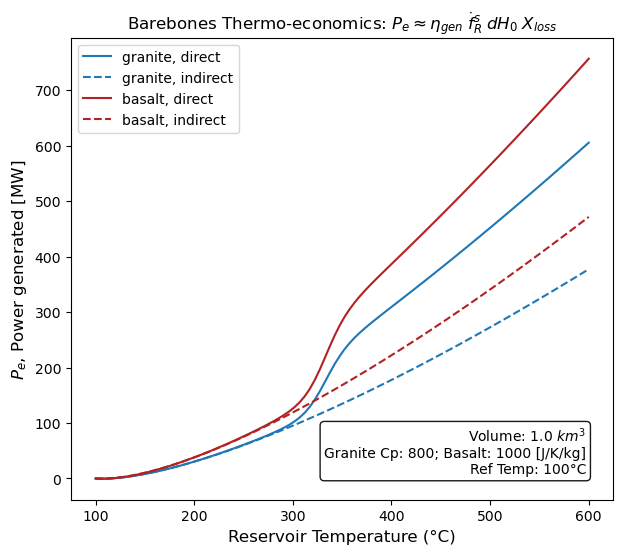

In [80]:
legend_list = []
fig, ax = plt.subplots(1, figsize=(7,6))

for d in d_list:
    plt.plot(T_reservoir_range_C,d['Pe_W']/1e6, color=d['color'], linestyle=d['marker'])
    legend_list.append(d['label'])

plt.title('Barebones Thermo-economics: $ P_e \\approx  \eta_{gen} \; \dot{f}^s_R \; dH_0 \; X_{loss} $', fontsize=12)
plt.xlabel('Reservoir Temperature (°C)', fontsize=12)
plt.ylabel('$P_{e}$, Power generated [MW]', fontsize=12)
plt.legend(legend_list)


# Add a text box for global parameters on the Right Plot
info_text = (f"Volume: 1.0 $km^3$\n"
             f"Granite Cp: {d1['Cp0']}; Basalt: {d3['Cp0']} [J/K/kg]\n"
             f"Ref Temp: 100°C")
plt.text(0.95, 0.05, info_text, transform=ax.transAxes, fontsize=10,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))


50.0
